<a href="https://colab.research.google.com/github/KyoungmiKwon/Bigdata_Training_at_ITwill/blob/main/Team_Project/C05_KM_KoBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 코렙에 설치 하기

    1. 케라스에서 Bert 활용을 쉽게 만들어주는 모듈 keras-bert를 설치
    2. Adam optimizer의 수정판인 keras-radam 모듈을 임포트
    3. HuggingFace는 자연어 처리 인공지능 모델에서, BERT 모델 같은 트랜스포머 모델들을 쉽게 다룰 수 있게 해주는 패키지  설치

In [ ]:
!pip install keras-bert  # keras-bert를 설치
!pip install keras-radam # keras-radam 모듈을 임포트
!pip install transformers # huggingFace  설치
!pip install sentencepiece 
!pip install tensorflow_addons # Rectified Adam 옵티마이저

# import

In [50]:
import tensorflow as tf

import pandas as pd
import numpy as np  
import re
from sklearn.model_selection import train_test_split

import keras as keras
from keras.models import load_model
from keras import backend as K
from keras import Input, Model
from keras import optimizers

from transformers import *
from tqdm import tqdm #  used to add progress bars that show the processing behind the execution of the program
import os
import sentencepiece as spm

from keras_bert import Tokenizer

from keras_radam import RAdam
import tensorflow_addons as tfa

# Bert input 생성

## Tokenizer from huggingface

        < 버트인풋 만들기>
        한글 데이터를 분석하려면, 100개가 넘는 언어에 대해 훈련된 버트를 사용해야 합니다.
        이번에는 한국어 데이터로 훈련되었고, SKT에서 만든 KoBERT를 사용하도록 하겠습니다.
        모델을 로드하기에 앞서, 토크나이저를 불러오도록 하겠습니다.
        huggingface에서는 아주 쉽게 토크나이저를 불러올 수 있습니다.
        https://github.com/monologg/KoBERT-NER 에서 kobert를 tokenize 할 수 있는 코드를 가져왔습니다.

In [13]:
import logging
import os
import unicodedata
from shutil import copyfile

from transformers import PreTrainedTokenizer


logger = logging.getLogger(__name__)

VOCAB_FILES_NAMES = {"vocab_file": "tokenizer_78b3253a26.model",
                     "vocab_txt": "vocab.txt"}

PRETRAINED_VOCAB_FILES_MAP = {
    "vocab_file": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/tokenizer_78b3253a26.model",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/tokenizer_78b3253a26.model",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/tokenizer_78b3253a26.model"
    },
    "vocab_txt": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/vocab.txt",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/vocab.txt",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/vocab.txt"
    }
}

PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES = {
    "monologg/kobert": 512,
    "monologg/kobert-lm": 512,
    "monologg/distilkobert": 512
}

PRETRAINED_INIT_CONFIGURATION = {
    "monologg/kobert": {"do_lower_case": False},
    "monologg/kobert-lm": {"do_lower_case": False},
    "monologg/distilkobert": {"do_lower_case": False}
}

SPIECE_UNDERLINE = u'▁'


class KoBertTokenizer(PreTrainedTokenizer):
    """
        SentencePiece based tokenizer. Peculiarities:
            - requires `SentencePiece <https://github.com/google/sentencepiece>`_
    """
    vocab_files_names = VOCAB_FILES_NAMES
    pretrained_vocab_files_map = PRETRAINED_VOCAB_FILES_MAP
    pretrained_init_configuration = PRETRAINED_INIT_CONFIGURATION
    max_model_input_sizes = PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES

    def __init__(
            self,
            vocab_file,
            vocab_txt,
            do_lower_case=False,
            remove_space=True,
            keep_accents=False,
            unk_token="[UNK]",
            sep_token="[SEP]",
            pad_token="[PAD]",
            cls_token="[CLS]",
            mask_token="[MASK]",
            **kwargs):
        super().__init__(
            unk_token=unk_token,
            sep_token=sep_token,
            pad_token=pad_token,
            cls_token=cls_token,
            mask_token=mask_token,
            **kwargs
        )

        # Build vocab
        self.token2idx = dict()
        self.idx2token = []
        with open(vocab_txt, 'r', encoding='utf-8') as f:
            for idx, token in enumerate(f):
                token = token.strip()
                self.token2idx[token] = idx
                self.idx2token.append(token)

        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")

        self.do_lower_case = do_lower_case
        self.remove_space = remove_space
        self.keep_accents = keep_accents
        self.vocab_file = vocab_file
        self.vocab_txt = vocab_txt

        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(vocab_file)

    @property
    def vocab_size(self):
        return len(self.idx2token)

    def get_vocab(self):
        return dict(self.token2idx, **self.added_tokens_encoder)

    def __getstate__(self):
        state = self.__dict__.copy()
        state["sp_model"] = None
        return state

    def __setstate__(self, d):
        self.__dict__ = d
        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")
        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(self.vocab_file)

    def preprocess_text(self, inputs):
        if self.remove_space:
            outputs = " ".join(inputs.strip().split())
        else:
            outputs = inputs
        outputs = outputs.replace("``", '"').replace("''", '"')

        if not self.keep_accents:
            outputs = unicodedata.normalize('NFKD', outputs)
            outputs = "".join([c for c in outputs if not unicodedata.combining(c)])
        if self.do_lower_case:
            outputs = outputs.lower()

        return outputs

    def _tokenize(self, text, return_unicode=True, sample=False):
        """ Tokenize a string. """
        text = self.preprocess_text(text)

        if not sample:
            pieces = self.sp_model.EncodeAsPieces(text)
        else:
            pieces = self.sp_model.SampleEncodeAsPieces(text, 64, 0.1)
        new_pieces = []
        for piece in pieces:
            if len(piece) > 1 and piece[-1] == str(",") and piece[-2].isdigit():
                cur_pieces = self.sp_model.EncodeAsPieces(piece[:-1].replace(SPIECE_UNDERLINE, ""))
                if piece[0] != SPIECE_UNDERLINE and cur_pieces[0][0] == SPIECE_UNDERLINE:
                    if len(cur_pieces[0]) == 1:
                        cur_pieces = cur_pieces[1:]
                    else:
                        cur_pieces[0] = cur_pieces[0][1:]
                cur_pieces.append(piece[-1])
                new_pieces.extend(cur_pieces)
            else:
                new_pieces.append(piece)

        return new_pieces

    def _convert_token_to_id(self, token):
        """ Converts a token (str/unicode) in an id using the vocab. """
        return self.token2idx.get(token, self.token2idx[self.unk_token])

    def _convert_id_to_token(self, index, return_unicode=True):
        """Converts an index (integer) in a token (string/unicode) using the vocab."""
        return self.idx2token[index]

    def convert_tokens_to_string(self, tokens):
        """Converts a sequence of tokens (strings for sub-words) in a single string."""
        out_string = "".join(tokens).replace(SPIECE_UNDERLINE, " ").strip()
        return out_string

    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks
        by concatenating and adding special tokens.
        A KoBERT sequence has the following format:
            single sequence: [CLS] X [SEP]
            pair of sequences: [CLS] A [SEP] B [SEP]
        """
        if token_ids_1 is None:
            return [self.cls_token_id] + token_ids_0 + [self.sep_token_id]
        cls = [self.cls_token_id]
        sep = [self.sep_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep

    def get_special_tokens_mask(self, token_ids_0, token_ids_1=None, already_has_special_tokens=False):
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` or ``encode_plus`` methods.
        Args:
            token_ids_0: list of ids (must not contain special tokens)
            token_ids_1: Optional list of ids (must not contain special tokens), necessary when fetching sequence ids
                for sequence pairs
            already_has_special_tokens: (default False) Set to True if the token list is already formated with
                special tokens for the model
        Returns:
            A list of integers in the range [0, 1]: 0 for a special token, 1 for a sequence token.
        """

        if already_has_special_tokens:
            if token_ids_1 is not None:
                raise ValueError(
                    "You should not supply a second sequence if the provided sequence of "
                    "ids is already formated with special tokens for the model."
                )
            return list(map(lambda x: 1 if x in [self.sep_token_id, self.cls_token_id] else 0, token_ids_0))

        if token_ids_1 is not None:
            return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1)) + [1]
        return [1] + ([0] * len(token_ids_0)) + [1]

    def create_token_type_ids_from_sequences(self, token_ids_0, token_ids_1=None):
        """
        Creates a mask from the two sequences passed to be used in a sequence-pair classification task.
        A KoBERT sequence pair mask has the following format:
        0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
        | first sequence    | second sequence
        if token_ids_1 is None, only returns the first portion of the mask (0's).
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return len(cls + token_ids_0 + sep) * [0]
        return len(cls + token_ids_0 + sep) * [0] + len(token_ids_1 + sep) * [1]

    def save_vocabulary(self, save_directory):
        """ Save the sentencepiece vocabulary (copy original file) and special tokens file
            to a directory.
        """
        if not os.path.isdir(save_directory):
            logger.error("Vocabulary path ({}) should be a directory".format(save_directory))
            return

        # 1. Save sentencepiece model
        out_vocab_model = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_file"])

        if os.path.abspath(self.vocab_file) != os.path.abspath(out_vocab_model):
            copyfile(self.vocab_file, out_vocab_model)

        # 2. Save vocab.txt
        index = 0
        out_vocab_txt = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_txt"])
        with open(out_vocab_txt, "w", encoding="utf-8") as writer:
            for token, token_index in sorted(self.token2idx.items(), key=lambda kv: kv[1]):
                if index != token_index:
                    logger.warning(
                        "Saving vocabulary to {}: vocabulary indices are not consecutive."
                        " Please check that the vocabulary is not corrupted!".format(out_vocab_txt)
                    )
                    index = token_index
                writer.write(token + "\n")
                index += 1

        return out_vocab_model, out_vocab_txt

kobert 토크나이즈

In [14]:
# Kobert 토크나이즈를 임포트
tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')

## change to Bert input

    huggingface에서는 순서가 [토큰 인풋, 마스크 인풋, 세그먼트 인풋]
    bertinput [토큰 인풋, 세그먼트 인풋, 마스크 인풋]으로 변환 
    
    tokenizer.encode => 문장을 버트 모델의 인풋 토큰값으로 바꿔줌
    tokenizer.tokenize => 문장을 토큰화


In [156]:
def convert_data(data_df):
    global tokenizer # 위의 함수에서 가져 옴(Tokenizer from huggingface)
    
    SEQ_LEN = 300 #SEQ_LEN : 버트에 들어갈 인풋의 길이
    
    tokens, masks, segments, targets = [], [], [], []
    
    for i in tqdm(range(len(data_df))):
        # token : 문장을 토큰화함
        token = tokenizer.encode(data_df['Text'][i], truncation=True, padding='max_length', max_length=SEQ_LEN)
       
        # 마스크는 토큰화한 문장에서 패딩이 아닌 부분은 1, 패딩인 부분은 0으로 통일
        num_zeros = token.count(0)
        mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros
        
        # 문장의 전후관계를 구분해주는 세그먼트는 문장이 1개밖에 없으므로 모두 0
        segment = [0]*SEQ_LEN

        # 버트 인풋으로 들어가는 token, mask, segment를 tokens, segments에 각각 저장
        tokens.append(token)
        masks.append(mask)
        segments.append(segment)
        
        # 정답(긍정 : 1 부정 0)을 targets 변수에 저장해 줌
        targets.append(data_df['S'][i])

    # tokens, masks, segments, 정답 변수 targets를 numpy array로 지정    
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)

    return [tokens, masks, segments], targets

# 위에 정의한 convert_data 함수를 불러오는 함수를 정의
def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_x, data_y = convert_data(data_df)
    return data_x, data_y

# 데이터 불러오기

In [172]:
file_path = '/content/drive/MyDrive/Colab Notebooks/Project/news_dt.xlsx' # 
file_path = '/content/gdrive/MyDrive/Colab Notebooks/Project/news_dt.xlsx' #코렙에서 쥬피터노트북으로 구글드라이브 마운트시
data = pd.read_excel(file_path,sheet_name='Sheet1',header=0)

In [163]:
print(len(data))

1354


# 세트 나누기

In [164]:
# 부정,중립,긍정으로 할 경우
X = pd.DataFrame(data['Text'])
y = pd.DataFrame(data['S'])

In [173]:
# 긍정, 긍정이 아닌 경우 : 이진분류로 치환시
y_1 = data['S'].replace(0,-1)
y = pd.DataFrame(y_1)

In [174]:
X_tr, X_ts, y_tr, y_ts = train_test_split(X,y,             
                                          test_size = 0.2,
                                          stratify = y)

In [175]:
# change to Bert input
SEQ_LEN = 300 # 위에 있는 "def convert_data(data_df) 의 SEQ_LEN "도 바꿔주기  
a = pd.concat([X_tr,y_tr],axis=1).reset_index(drop=True)
b = pd.concat([X_ts,y_ts],axis=1).reset_index(drop=True)

In [176]:
X_tr, y_tr = load_data(a)
X_ts, y_ts = load_data(b)

100%|██████████| 271/271 [00:00<00:00, 439.31it/s]


In [177]:
np.unique(y_tr, return_counts=True),np.unique(y_ts, return_counts=True)

((array([-1,  1]), array([543, 540])), (array([-1,  1]), array([136, 135])))

In [178]:
X_tr[:2]

[array([[   2,  517, 6181, ..., 7207, 6673,    3],
        [   2,  517, 6013, ..., 7096, 3812,    3],
        [   2, 3711, 7005, ..., 7096, 1698,    3],
        ...,
        [   2, 4049,  517, ..., 2547, 1208,    3],
        [   2, 4693, 6964, ..., 6903,  517,    3],
        [   2, 4049, 4737, ..., 6450, 4826,    3]]),
 array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]])]

# Bert를 사용한 모델 생성

In [179]:
md = TFBertModel.from_pretrained("monologg/kobert", from_pt=True)

All PyTorch model weights were used when initializing TFBertModel.

All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [180]:
# 토큰 인풋, 마스크 인풋, 세그먼트 인풋 정의
token_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_word_ids')
mask_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_masks')
segment_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_segment')
# 인풋이 [토큰, 마스크, 세그먼트]인 모델 정의
bert_outputs = md([token_inputs, mask_inputs, segment_inputs])

In [181]:
a = bert_outputs[1]

In [182]:
# optimizer = Rectified Adam 사용
opt = tfa.optimizers.RectifiedAdam(lr=5.0e-5, total_steps = 2344*2, warmup_proportion=0.1, min_lr=1e-5, epsilon=1e-08, clipnorm=1.0)

In [183]:
sentiment_drop = tf.keras.layers.Dropout(0.5)(a)
sentiment_first = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(sentiment_drop)

In [184]:
model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], sentiment_first)

In [185]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_segment (InputLayer)      [(None, 300)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_4 (TFBertModel)   TFBaseModelOutputWit 92186880    input_word_ids[0][0]             
                                                                 input_masks[0][0]          

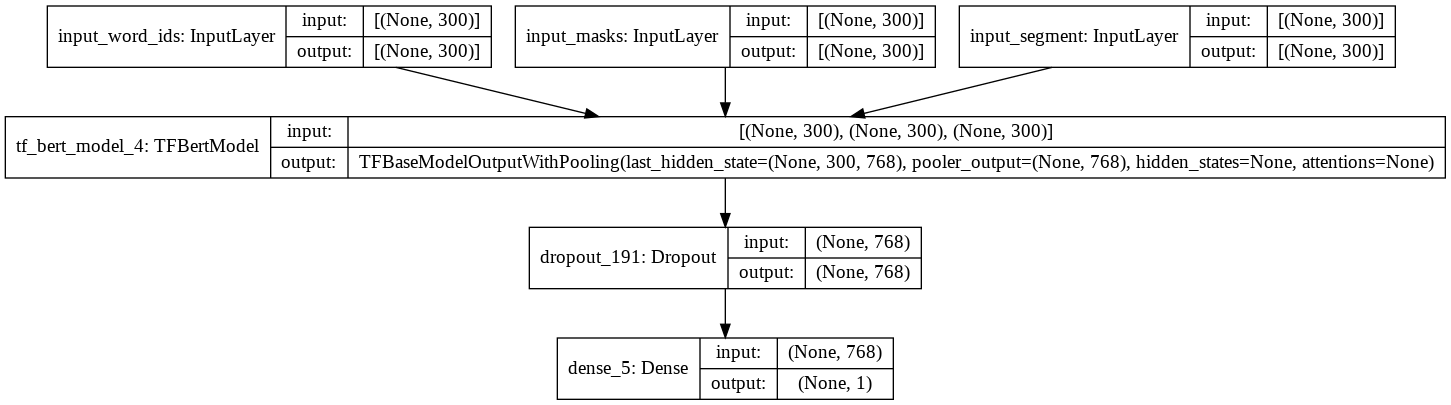

In [186]:
keras.utils.plot_model(model, show_shapes=True)

In [187]:
# 모델 컴파일
model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])

# 모델 훈련

In [188]:
# 콜백(조기 종료, 상태 저장)
early_stop = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
check_point = keras.callbacks.ModelCheckpoint('bert_model.h5', save_best_only=True)

In [ ]:
# 훈련
history = model.fit(X_tr,y_tr,
                    batch_size=64, epochs=1000,
                    validation_split = 0.2, validation_batch_size=64,
                    callbacks=[early_stop,check_point])

Epoch 1/1000
